In [1]:
from PIL import Image
import requests
import io
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import pyocr

In [3]:
judges = ['PERFECT', 'GREAT', 'GOOD', 'BAD', 'MISS']

tools = pyocr.get_available_tools()
tool = tools[0]

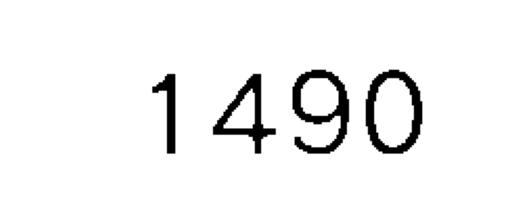

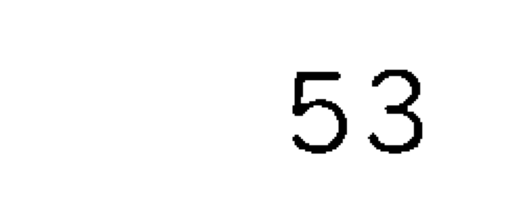

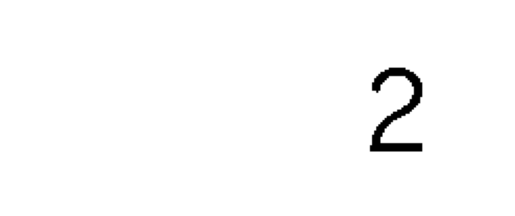

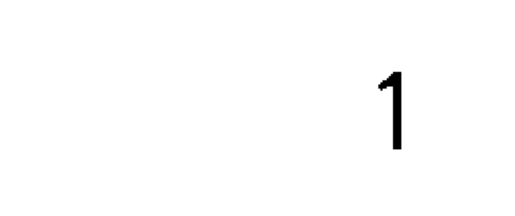

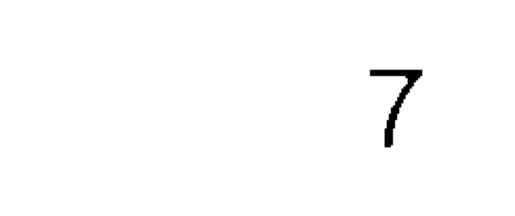

{'PERFECT': '1490', 'GREAT': '53', 'GOOD': '2', 'BAD': '1', 'MISS': '7'}


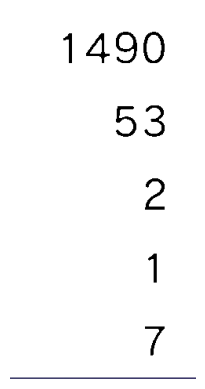

In [13]:
def searchPosition(templ_img, query_img, good_match_rate=0.30):
    # https://qiita.com/sitar-harmonics/items/41d54dbfc6c81b87b905
    
    # A-KAZE検出器の生成
    detector = cv2.AKAZE_create()
    templ_kp, templ_des = detector.detectAndCompute(templ_img, None)

    # 特徴量の検出と特徴量ベクトルの計算
    query_kp, query_des = detector.detectAndCompute(query_img, None)

    # マッチング
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # 特徴量ベクトル同士をマッチング
    matches = bf.match(query_des, templ_des)

    # 特徴量をマッチング状況に応じてソート
    matches = sorted(matches, key = lambda x:x.distance)
    good = matches[:int(len(matches) * good_match_rate)]

    # 位置計算
    src_pts = np.float32([templ_kp[m.trainIdx].pt for m in good])
    dst_pts = np.float32([query_kp[m.queryIdx].pt for m in good])
    Mx, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)

    # 画像４隅の角座標を取得
    th = templ_img.shape[0]
    tw = templ_img.shape[1]
    pts = np.array([[[0,0], [0,th-1],[tw-1,th-1],[tw-1,0]]], dtype=np.float32)
    dst = cv2.perspectiveTransform(pts,Mx)
    return  Mx, np.int32(dst)


from_img = cv2.cvtColor(cv2.imread('./template.png'), cv2.COLOR_BGR2RGB)
to_img = cv2.cvtColor(cv2.imread('./IMG_8927.png'), cv2.COLOR_BGR2RGB)
to_img = to_img[to_img.shape[0] // 2:to_img.shape[0], 0:to_img.shape[1] // 2]

Mx, dst = searchPosition(templ_img=from_img, query_img=to_img)

x, y = np.sort(dst[0,:,0]), np.sort(dst[0,:,1])

img = to_img[y[0] : y[3] , x[3] : x[3] + math.floor((x[3] - x[0]) / 5 * 4)]

datas = {}
hight = img.shape[0] // 5

border = 230
blur = True
psm = 6

builder = pyocr.builders.DigitBuilder(tesseract_layout=psm)

for i in range(len(judges)):
    cropped_img = img[hight * i : hight * (i + 1), 0 : img.shape[1]]

    # convert to grayscale
    r, g, b = cropped_img[:, :, 0], cropped_img[:, :, 1], cropped_img[:, :, 2]
    mask = np.logical_and(r >= border, np.logical_and(g >= border, b >= border))
    cropped_img[mask] = [0, 0, 0]
    cropped_img[np.logical_not(mask)] = [255, 255, 255]

    plt.imshow(cropped_img)
    plt.axis('off')
    plt.show()
    
    # 余白作成とblur
    if blur:
        cropped_img = cv2.blur(cropped_img, (3, 3))
    cropped_img = cv2.copyMakeBorder(cropped_img, 100, 100, 100, 100, cv2.BORDER_CONSTANT, value=[255,255,255])  

    result = tool.image_to_string(Image.fromarray(cropped_img), lang='eng', builder=builder)
    datas[judges[i]] = result

print(datas)

plt.imshow(img)
plt.axis('off')
plt.show()